In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Inspect the measurement table to get the column names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [9]:
# measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [47]:
# Exploratory Precipitation Analysis
# Find the most recent date in the data set.
current_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
current_date

('2017-08-23')

In [50]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
query_enddate = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_enddate 

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores
query_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_enddate).all()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# See 09-Par_Emoji plotting for sample code
measure_df = pd.DataFrame(query_data, columns = ['date', 'prcp'])
measure_df.set_index('date', inplace=True)
measure_df

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [16]:
# Remove NANs
measure_df = measure_df.dropna()
# measure_df

In [17]:
# Sort the dataframe by date
measure_df =measure_df.sort_index()

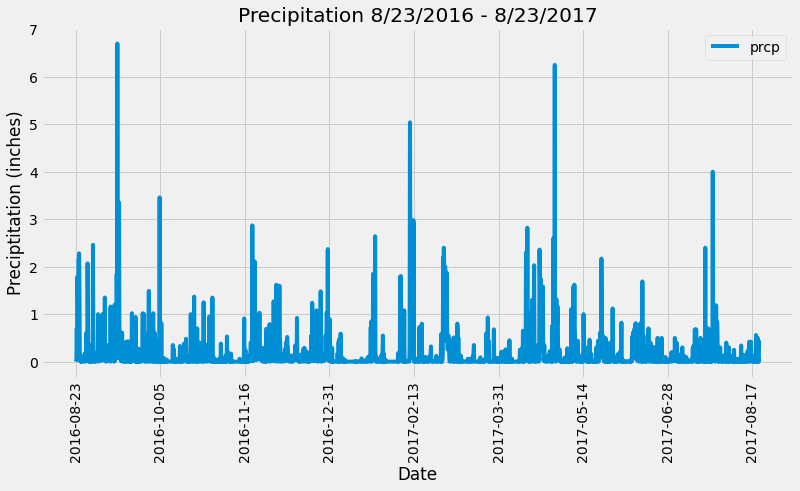

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
#plt.bar(df["date"], df["prcp"], color="blue", alpha=0.5, align="center")
measure_df.plot(rot=90, figsize=(12,6))
plt.title("Precipitation 8/23/2016 - 8/23/2017")
plt.ylabel("Preciptitation (inches)")
plt.xlabel("Date")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measure_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).count()

9

In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
# See sample in 10-Advanced-Data-Storage-and-Retrieval
session.query(func.count(Measurement.station)).group_by(Measurement.station).all()

[(1979), (2709), (2202), (2612), (1372), (511), (2772), (2724), (2669)]

In [22]:
# Had trouble generating the list, TA Farshad helped
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# 'USC00519281', 2772
query_data2 = session.query(Measurement.date, Measurement.station, Measurement.tobs ).filter(Measurement.station == "USC00519281").all()

In [24]:
mostactive_df = pd.DataFrame(query_data2, columns = ['date', 'station', 'tobs'])
mostactive_df.set_index('date', inplace=True)
mostactive_df.describe()

,tobs
count,2772.000000
mean,71.663781
std,4.357642
min,54.000000
25%,69.000000
50%,72.000000
75%,74.000000
max,85.000000


In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mostactive2_df = mostactive_df.sort_values('date', ascending=False)
mostactive2_df

,station,tobs
date,,
2017-08-18,USC00519281,79.0
2017-08-17,USC00519281,76.0
2017-08-16,USC00519281,76.0
2017-08-15,USC00519281,77.0
2017-08-14,USC00519281,77.0
...,...,...
2010-01-05,USC00519281,74.0
2010-01-04,USC00519281,75.0
2010-01-03,USC00519281,74.0


In [26]:
# Slice the data to get the 12 months of data (some data was removed due to NANs, so it may not be 365 days
mostactive2_df[:357]

,station,tobs
date,,
2017-08-18,USC00519281,79.0
2017-08-17,USC00519281,76.0
2017-08-16,USC00519281,76.0
2017-08-15,USC00519281,77.0
2017-08-14,USC00519281,77.0
...,...,...
2016-08-22,USC00519281,78.0
2016-08-21,USC00519281,79.0
2016-08-20,USC00519281,81.0


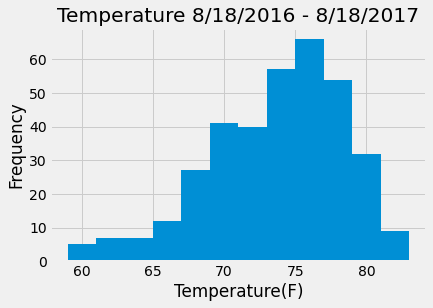

In [27]:
plt.hist(mostactive2_df[:357]['tobs'], bins=12)
plt.title("Temperature 8/18/2016 - 8/18/2017")
plt.xlabel('Temperature(F)')
plt.ylabel('Frequency')
plt.show()

# Close session

In [28]:
# Close Session
session.close()